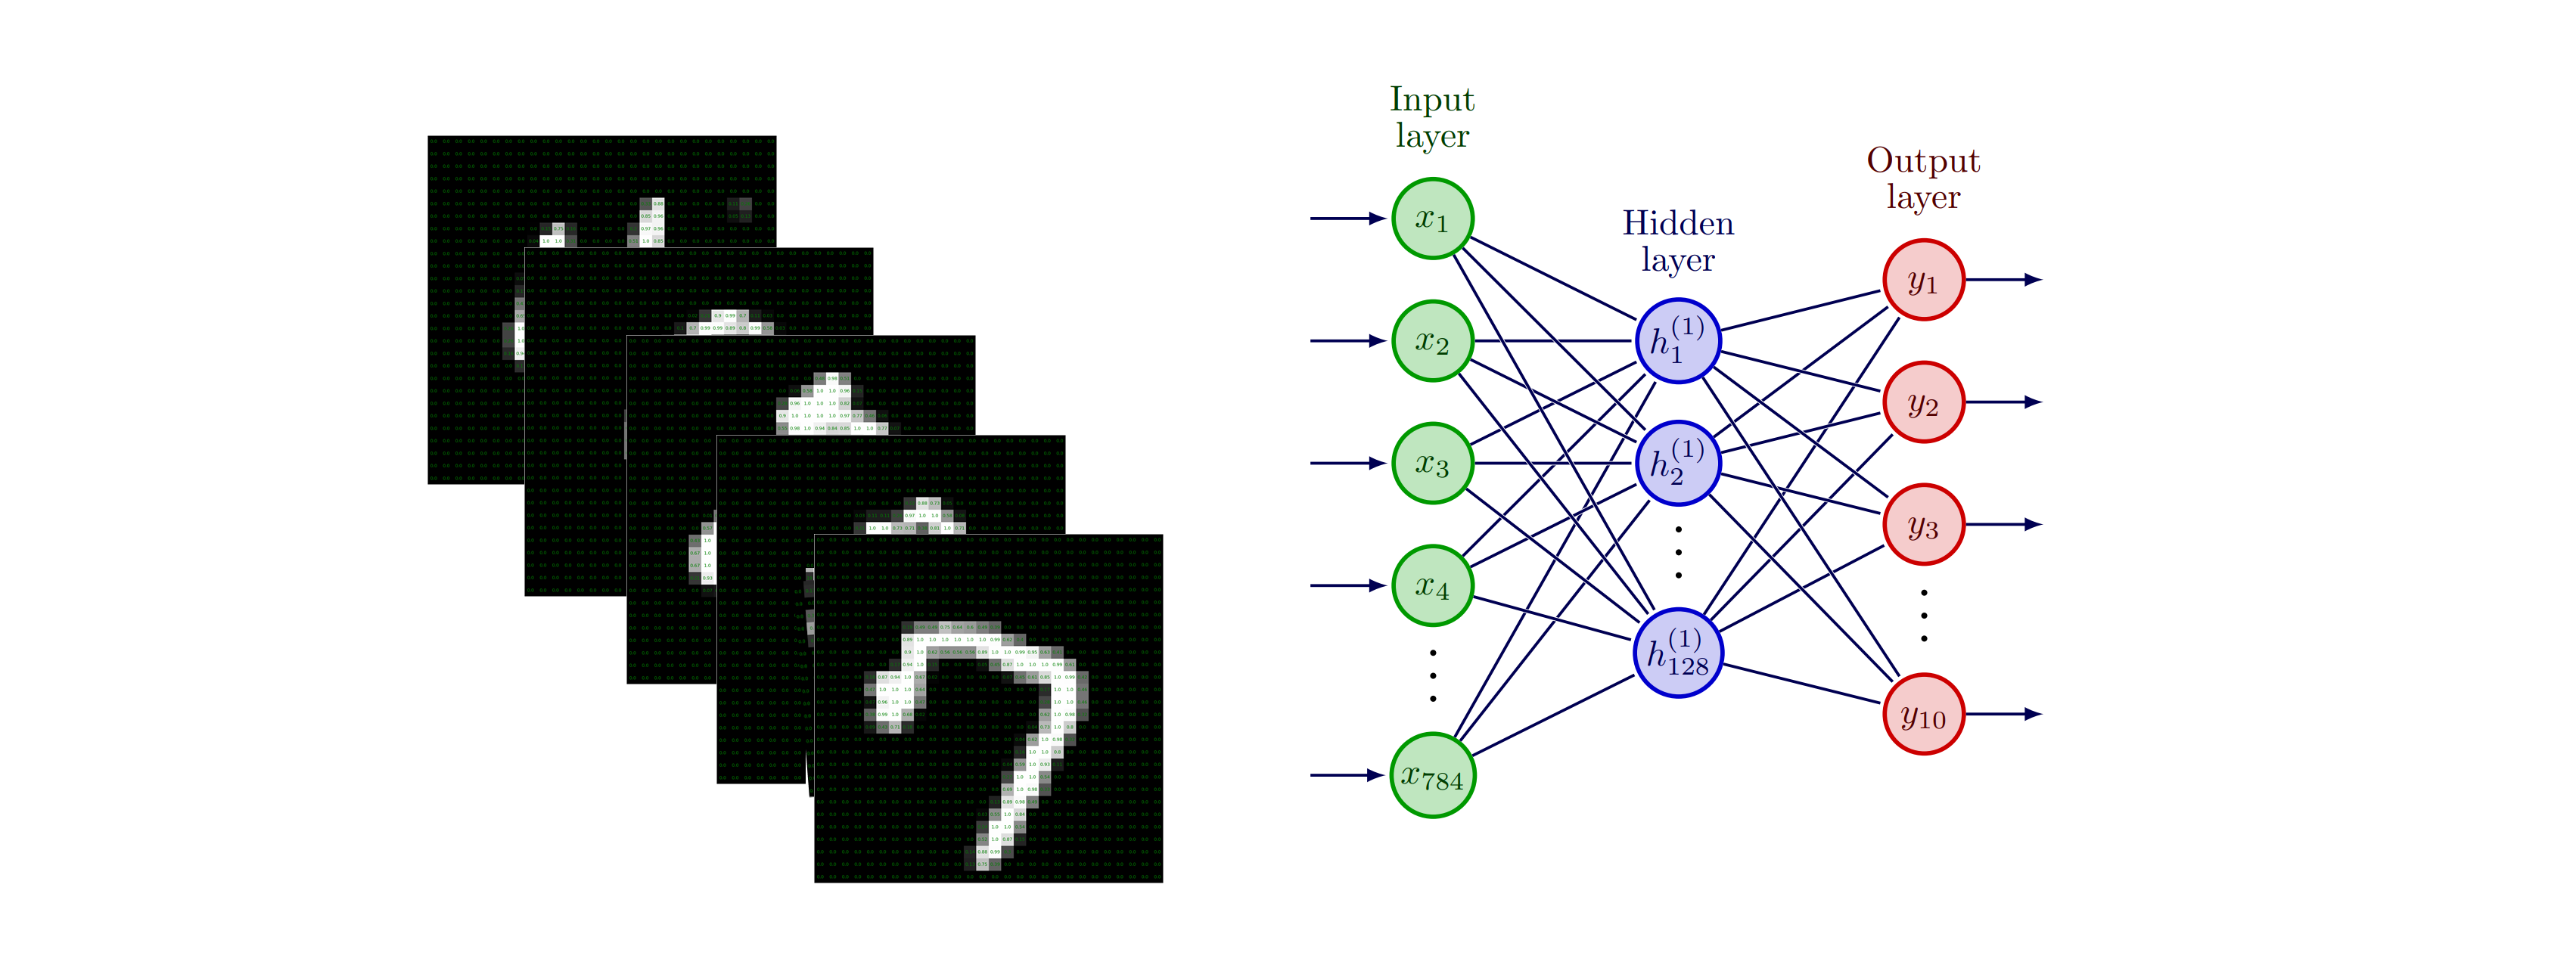

## Context
I've been using deep learning libraries for a long time now. Mainly, I've used PyTorch and PyTorch Lightning in my deep learning projects, but I also have some experience with TensorFlow and Keras. While these libraries simplify the entire process of training a model and offer excellent performance, I believe one can use these tools without actually understanding how they work. I, myself am guilty of using machine learning tools and libraries without fully understanding them. My goal with this notebook is to dive deep into the maths involved in neural networks and gain a better understanding of the underlying principles, including but not limited to gradient descent optimization, backpropagation, activation functions, weight initialization, and loss functions. I will be using the MNIST dataset for this project for its simplicity, and will build the architecture above to classify the digits in the dataset.

# Imports

I will use NumPy for the majority of this project. However, I will also import a few other libraries to read the data and make visualizations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

random.seed(27)
np.random.seed(27)
plt.style.use('ggplot')

# Loading and Processing Data

In [2]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
X_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

print(f"Train dataset shape: {train.shape}")
print(f"Test dataset shape: {X_test.shape}")

Train dataset shape: (42000, 785)
Test dataset shape: (28000, 784)


In [3]:
X_train = train.drop('label', axis=1)
y_train = train['label']

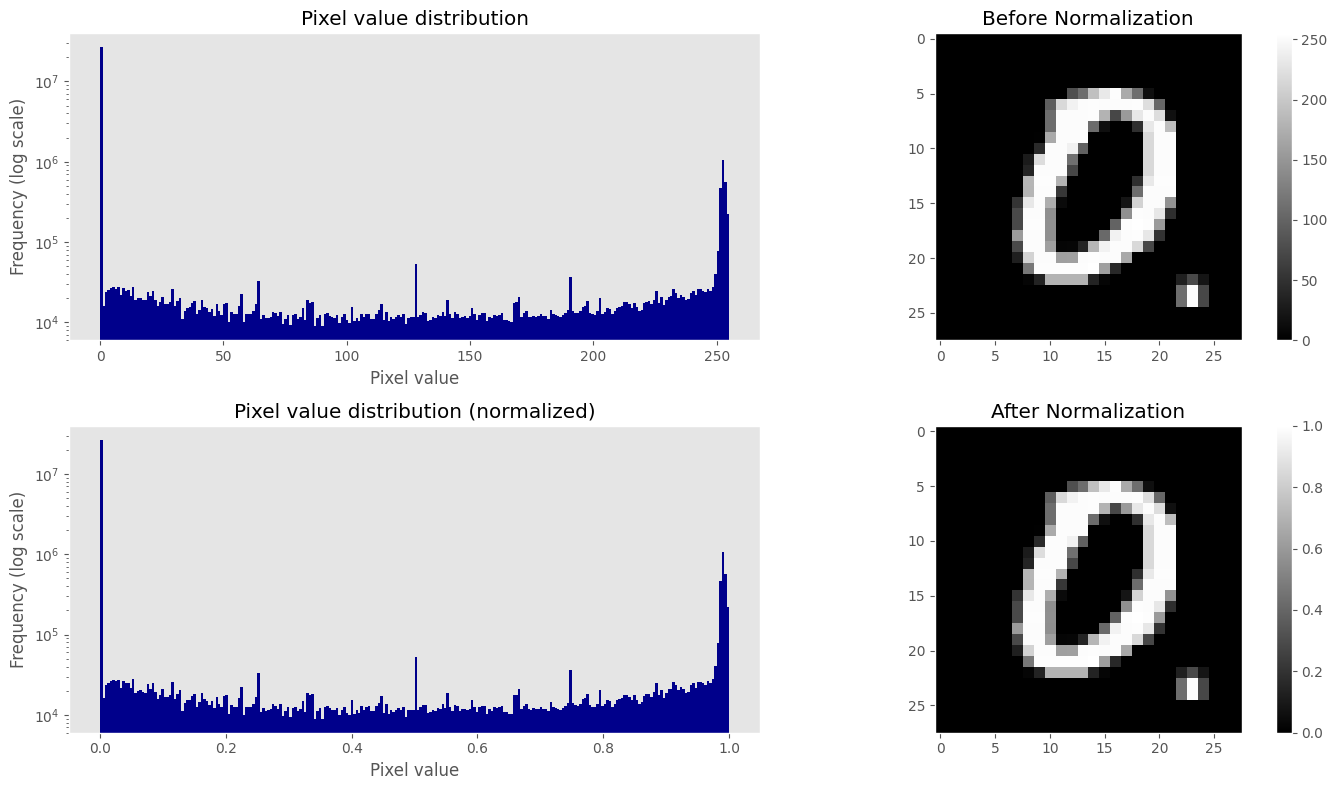

In [4]:
# Taking a random sample and normalizing it, keeping the original for comparison
random_index = np.random.choice(X_train.shape[0])
sample_before = X_train.iloc[random_index]
sample_after = sample_before / 255.0

plt.figure(figsize=(14, 8))
plt.rcParams['axes.grid'] = False

plt.subplot(2, 2, 1)
plt.hist(X_train.values.flatten(), bins=256, color='darkblue')
plt.title('Pixel value distribution')
plt.xlabel('Pixel value')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')

plt.subplot(2, 2, 2)
plt.imshow(sample_before.values.reshape(28, 28), cmap='gray')
plt.title('Before Normalization')
plt.colorbar()

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

plt.subplot(2, 2, 3)
plt.hist(X_train.values.flatten(), bins=256, color='darkblue')
plt.title('Pixel value distribution (normalized)')
plt.xlabel('Pixel value')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')

plt.subplot(2, 2, 4)
plt.imshow(sample_after.values.reshape(28, 28), cmap='gray')
plt.title('After Normalization')
plt.colorbar()

plt.tight_layout()
plt.show()

I will not do much to the dataset besides normalizing the pixel values to ensure all values are within the same range (0-1). This helps prevent issues such as exploding and vanishing gradients in the network. I will use the following formula:
```python
X_train = X_train / 255.0
```
As you can see in the plot above, normalization doesn't change the distibution of pixel values. It also doesn't change how the image looks like to the human eye. We can also look at how normalization affects the pixel values. The plot below shows the same image before and after normalization. The images look the same to us, however if you look closely, you can observe that the values after normalization are all within the range of 0 and 1.

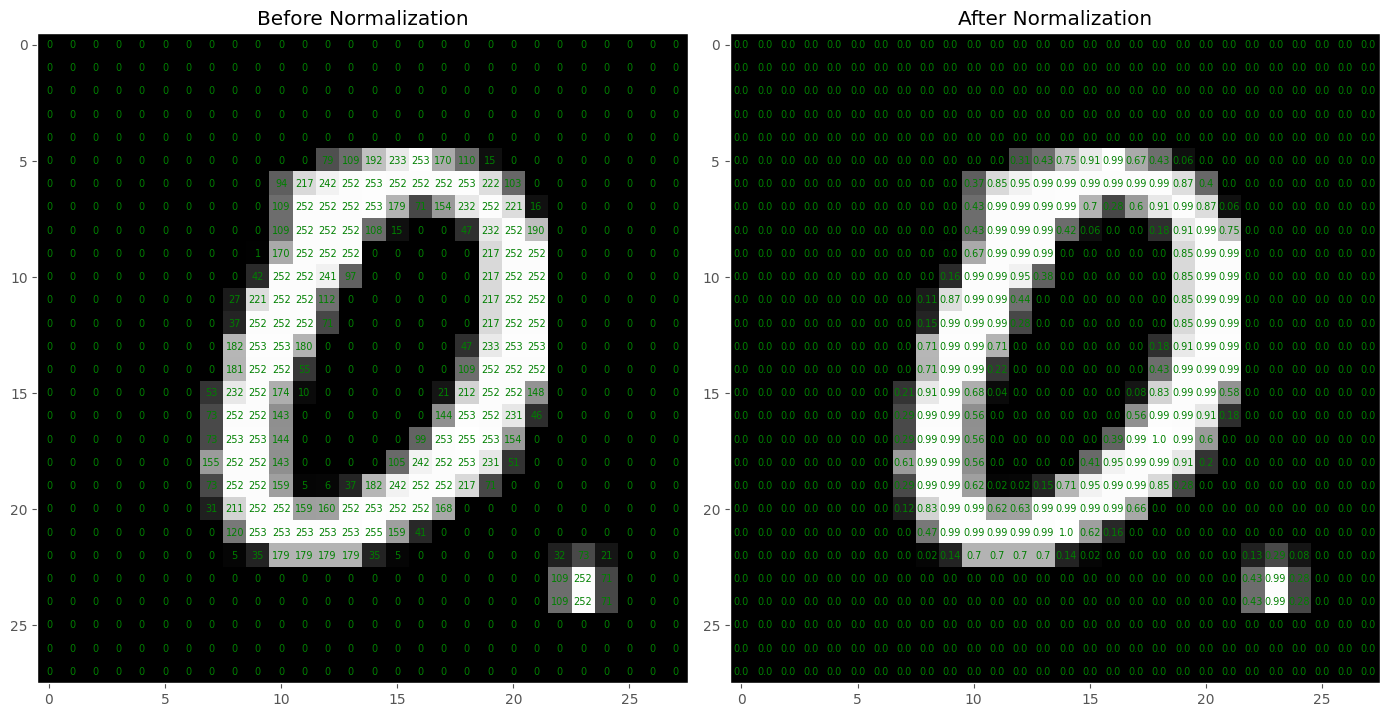

In [5]:
plt.figure(figsize=(14, 8))
plt.rcParams['axes.grid'] = False

plt.subplot(1, 2, 1)
plt.imshow(sample_before.values.reshape(28, 28), cmap='gray')
plt.title('Before Normalization')

for i in range(28):
    for j in range(28):
        plt.text(j, i, int(sample_before.values[i * 28 + j]), ha='center', va='center', color='green', fontsize=7)
        
plt.subplot(1, 2, 2)
plt.imshow(sample_after.values.reshape(28, 28), cmap='gray')
plt.title('After Normalization')

for i in range(28):
    for j in range(28):
        plt.text(j, i, round(sample_after.values[i * 28 + j], 2), ha='center', va='center', color='green', fontsize=7)

plt.tight_layout()
plt.savefig("image.png")
plt.show()

## One-Hot Encoding The Labels

The output layer of the network consists of 10 neurons, each representing one of the ten possible numbers. To ensure consistency in dimensionality across labels in the dataset and facilitate calculations of loss and other metrics, I will one-hot encode the labels. This will generate an array of length 10 for each label, where all elements are set to 0 except for the index corresponding to the label. In the provided code snippet, I have included examples of this transformation. You can observe the original label's transformation into a one-hot encoded vector.

In [6]:
y_train_samples = y_train[:10].values

num_classes = y_train.max() + 1
y_train = np.eye(num_classes)[y_train]
y_train = y_train.astype(int)

y_train_onehot_samples = y_train[:10]
for y, y_onehot in zip(y_train_samples, y_train_onehot_samples):
    print(f"Original label: {y} | One-hot encoded label: {y_onehot}")

Original label: 1 | One-hot encoded label: [0 1 0 0 0 0 0 0 0 0]
Original label: 0 | One-hot encoded label: [1 0 0 0 0 0 0 0 0 0]
Original label: 1 | One-hot encoded label: [0 1 0 0 0 0 0 0 0 0]
Original label: 4 | One-hot encoded label: [0 0 0 0 1 0 0 0 0 0]
Original label: 0 | One-hot encoded label: [1 0 0 0 0 0 0 0 0 0]
Original label: 0 | One-hot encoded label: [1 0 0 0 0 0 0 0 0 0]
Original label: 7 | One-hot encoded label: [0 0 0 0 0 0 0 1 0 0]
Original label: 3 | One-hot encoded label: [0 0 0 1 0 0 0 0 0 0]
Original label: 5 | One-hot encoded label: [0 0 0 0 0 1 0 0 0 0]
Original label: 3 | One-hot encoded label: [0 0 0 1 0 0 0 0 0 0]


# Creating a Simple Dataloader

In the below code I've implemented a generator functions that returns a batch of data. It is a highly simplified version of dataloader classes used in many deep learning libraries.

In [7]:
def get_batch(X, y, batch_size):
    n_batches = X.shape[0] // batch_size
    for i in range(n_batches):
        X_batch = X[i*batch_size:(i+1)*batch_size]
        y_batch = y[i*batch_size:(i+1)*batch_size]
        yield X_batch, y_batch

# Activation Functions
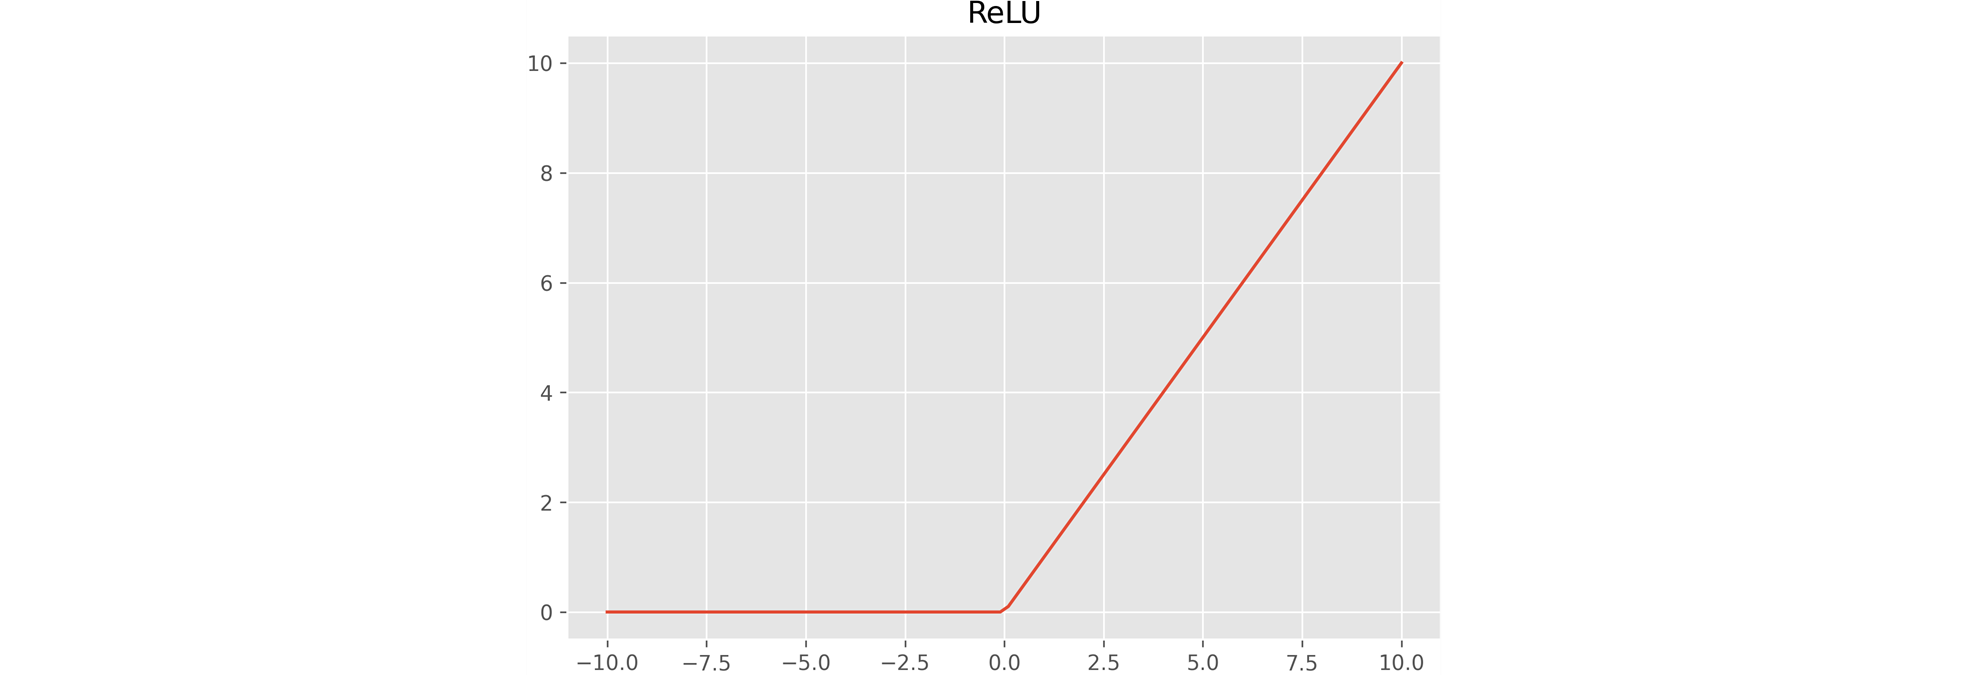

Before starting with forward pass, it is important to understand what activation functions are and why they are used in neural networks. Activation functions are mathematical functions applied to the output of each neuron in a neural network's hidden layers. They introduce non-linearity to the network, enabling it to learn complex patterns in data. Without activation functions, neural networks would essentially reduce to linear transformations, which limits their ability to learn complex relationships in data.

I've used two different activations functions in my network architecture, `Rectified Linear Unit (ReLU)` and `SoftMax`. The former is used in the hidden layer, and the latter is applied to the output layer. `ReLU` is one of the most widely used activation functions. It sets all negative values to zero and leaves positive values unchanged. For a given input value $x$, `ReLU` is defined as

\begin{equation}
    \text{ReLU}(x) = \text{max}(0, x)
\end{equation}

`SoftMax` is commonly used in the output layer of a neural network. It converts the raw output scores into probabilities, ensuring that the sum of the probabilities across all classes equals one. It is defined as

\begin{equation}
    p_i = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}
\end{equation}

The code for these functions is shown below. Note that I've also defined the derivative of `ReLU` as it is needed in backpropagation.

In [8]:
def relu(x):
    return np.maximum(x, 0)

In [9]:
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

In [10]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Forward Pass
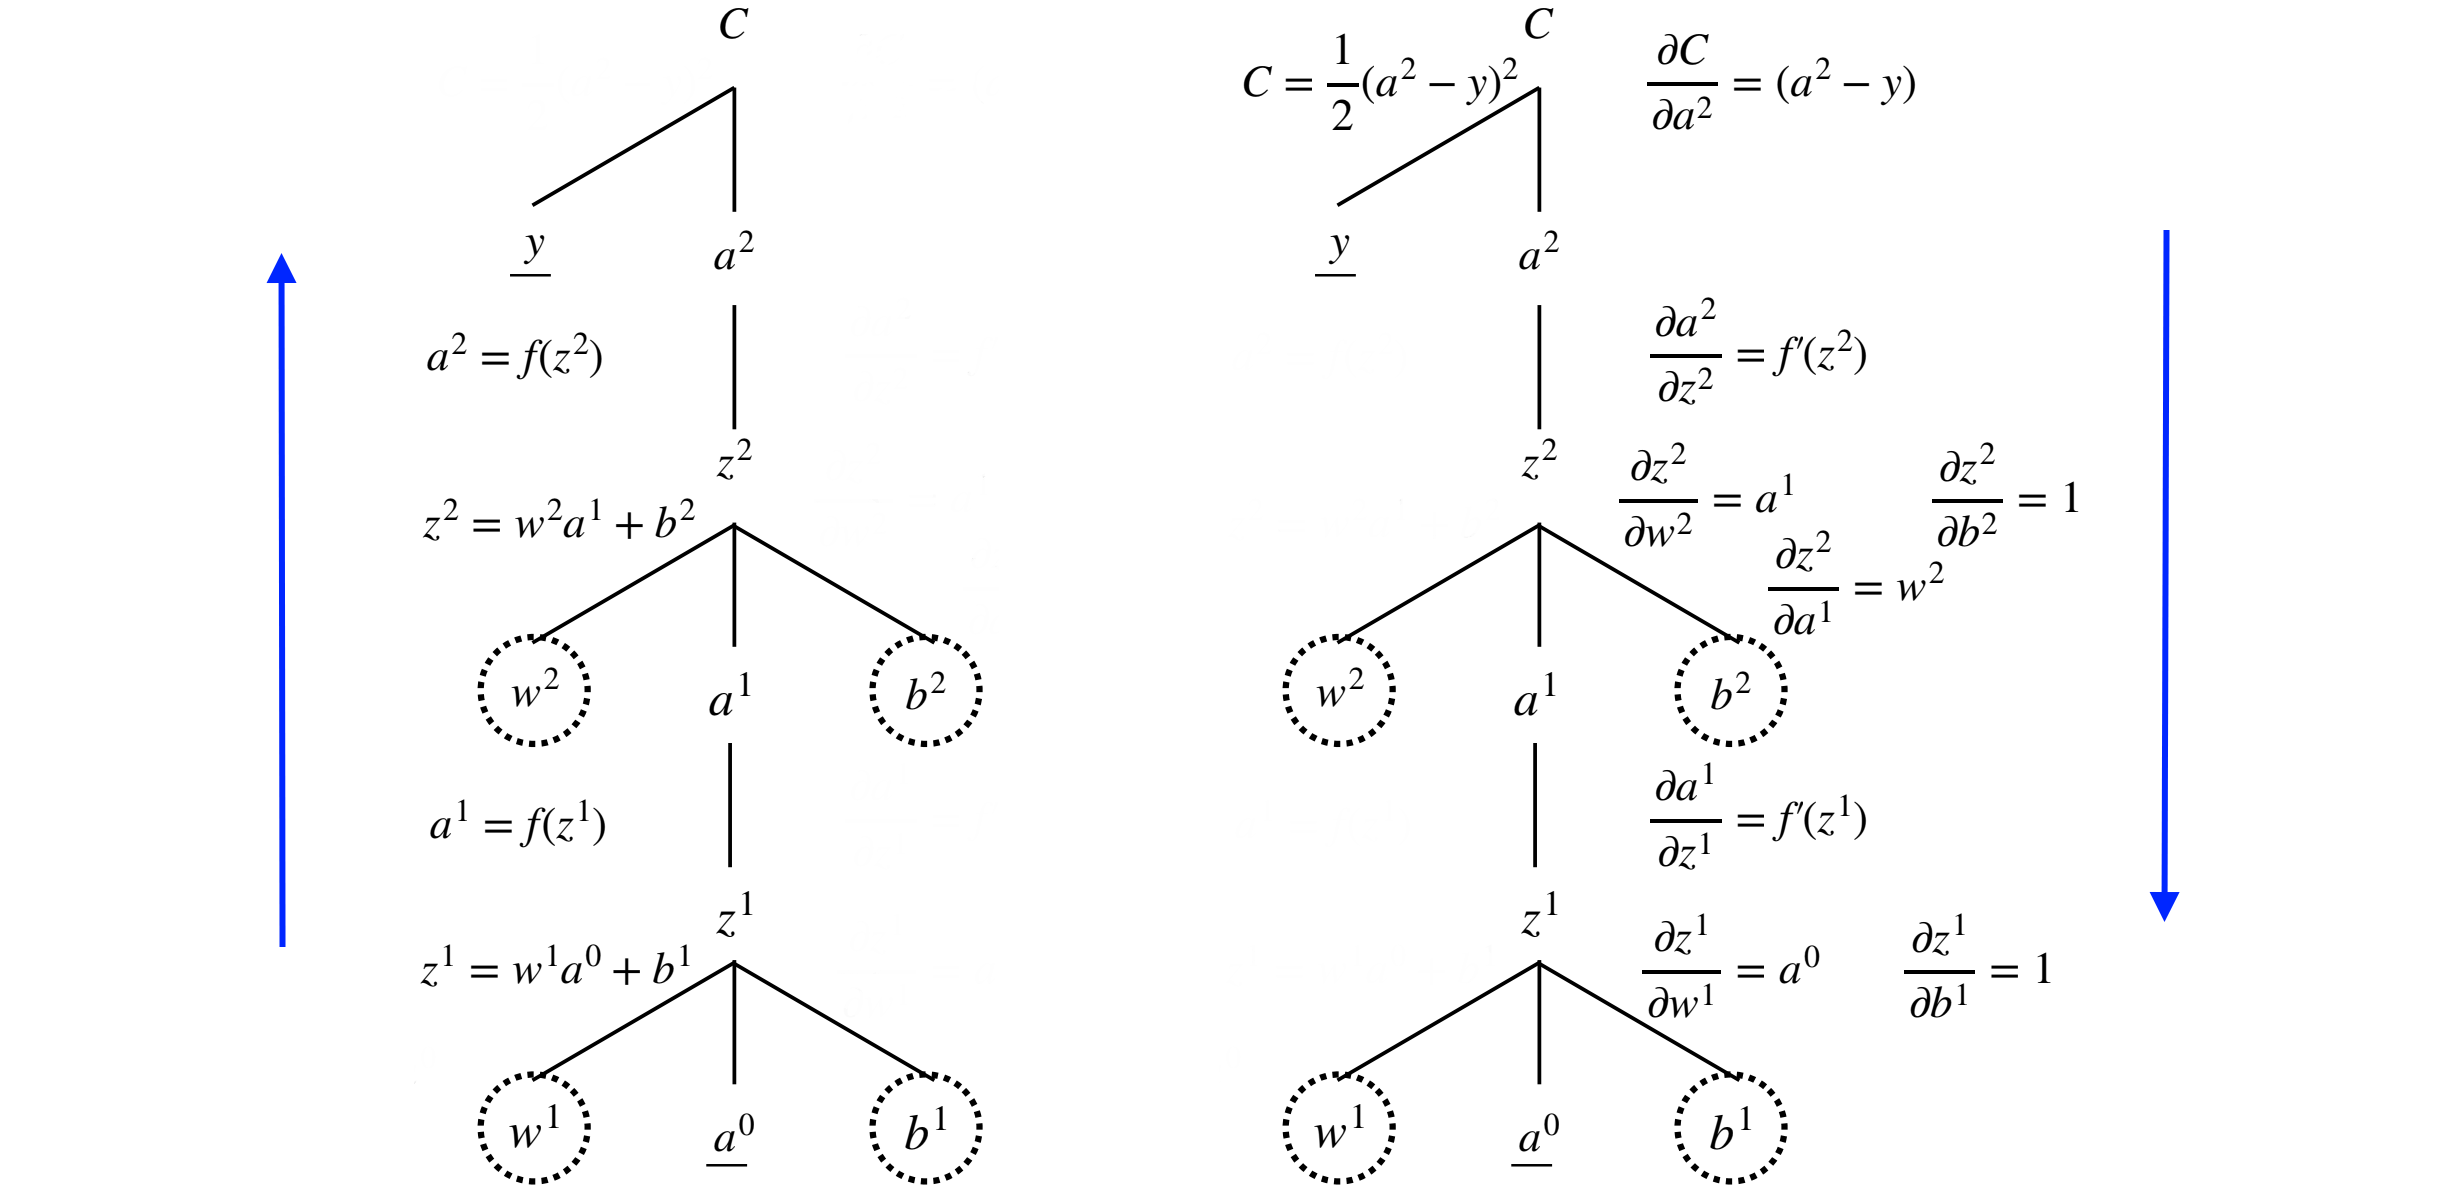

Finally, onto the main part of this notebook. I've found the tree structure above to be very useful when trying to understand the mathematical operations involved in forward and backward pass. On the left, we can see the equations of forward pass, and on the right, the equations of backpropagation.

### Input and Hidden Layer
Starting from the bottom, we have the input values, i.e. the flattened input images denoted as $x=a^0$. We also have the weights that connect the input layer to the first and only hidden layer, $w^1$, as well as the bias of the hidden layer denoted as $b^1$. These values are used to calculate the first weighted sum, $z^1$, as follows

\begin{equation}
    \begin{split}
        a^0 &= x \\
        z^1 &= w^1 a^0 + b^1
    \end{split}
\end{equation}

The weighted sum is passed through an activation function $f$, in this case, $f=\text{ReLU}$.

\begin{equation}
    a^1 = f(z^1) = \text{ReLU}(z^1)
\end{equation}


### Hidden and Output Layer
Now the output from the activation function of the hidden layer is used as the input to the next layer. this process repeats as many times as there are layers in the network. 

\begin{equation}
    \begin{split}
        z^2 &= w^2 a^1 + b^2 \\
        a^2 &= \text{SoftMax}(z^2)
    \end{split}
\end{equation}

The output of the last layer is special because the `SoftMax` function is applied to the neurons in this layer. The output of the activation function, $a^2$,  is what the network has predicted and is usually denoted as $\hat y$.

Finally, putting all the equations above together, and translating them into code, we end up with the function below.

In [11]:
def forward(X, W1, b1, W2, b2):
    z1 = X @ W1 + b1
    a1 = relu(z1)
    z2 = a1 @ W2 + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

# Backward Pass
In the previous section, we calculated the output, $a^2=\hat y$. This value alongside the ground truth label $y$ is run through a loss function. Ideally, at each iteration the value of the loss function should decrease, indicating the model's improving ability to learn. I've used the Mean Squared Error function (MSE) for this task. It is defined as
\begin{equation}
    C = \frac{1}{2}(a^2 - y)^2
\end{equation}

Now to calculate the changes that we need to make to the network parameters, we need to calculate the following gradients: $\frac{\partial C}{\partial w^2}$, $\frac{\partial C}{\partial b^2}$, $\frac{\partial C}{\partial w^1}$, and $\frac{\partial C}{\partial b^1}$. Starting with $\frac{\partial C}{\partial w^2}$ and $\frac{\partial C}{\partial b^2}$, using the chain rule, we get

\begin{equation}
    \begin{split}
        \frac{\partial C}{\partial w^2} &= \frac{\partial C}{\partial a^2} \frac{\partial a^2}{\partial z^2} \frac{\partial z^2}{\partial w^2} \\
        \frac{\partial C}{\partial b^2} &= \frac{\partial C}{\partial a^2} \frac{\partial a^2}{\partial z^2} \frac{\partial z^2}{\partial b^2}
    \end{split}
\end{equation}

We'll calculate each of these terms separately, and put them together at the end.

\begin{equation}
    \begin{split}
        \frac{\partial C}{\partial a^2} &= \frac{\partial}{\partial a^2}(\frac{1}{2}(a^2 - y)^2) = a^2 - y \\
        \frac{\partial a^2}{\partial z^2} &= \frac{\partial}{\partial z^2}f(z^2) = f'(z^2) \\
        \frac{\partial z^2}{\partial w^2} &= \frac{\partial}{\partial w^2}(w^2a^1+b^2) = a^1 \\
        \frac{\partial z^2}{\partial b^2} &= \frac{\partial}{\partial b^2}(w^2a^1+b^2) = 1
    \end{split}
\end{equation}

Now to make things simpler, we set $\delta^2 = \frac{\partial C}{\partial a^2} \frac{\partial a^2}{\partial z^2}=(a^2-y)f'(z^2)$. This simplifies $\frac{\partial C}{\partial w^2}$ as follows

\begin{equation}
    \frac{\partial C}{\partial w^2} = \delta^2 \frac{\partial z^2}{\partial w^2} = \delta^2a^1
\end{equation}

Similarly for the bias, we get

\begin{equation}
    \frac{\partial C}{\partial b^2} = \frac{\partial C}{\partial a^2} \frac{\partial a^2}{\partial z^2} \frac{\partial z^2}{\partial b^2} = \delta^2 \frac{\partial z^2}{\partial b^2} = \delta^2 \times 1 = \delta^2
\end{equation}

Now we apply the chain rule again for the first layer, and we get
\begin{equation}
    \frac{\partial C}{\partial w^1} = \frac{\partial C}{\partial a^2} \frac{\partial a^2}{\partial z^2} \frac{\partial z^2}{\partial a^1} \frac{\partial a^1}{\partial z^1} \frac{\partial z^1}{\partial w^1} = \delta^2 w^2 f'(z^1)a^0 = \delta^1a^0
\end{equation}

For the bias, we get,
\begin{equation}
    \frac{\partial C}{\partial b^1} = \frac{\partial C}{\partial a^2} \frac{\partial a^2}{\partial z^2} \frac{\partial z^2}{\partial a^1} \frac{\partial a^1}{\partial z^1} \frac{\partial z^1}{\partial b^1} = \delta^2 w^2 f'(z^1) = \delta^1
\end{equation}

Translating all this to code, we get the function below for backpropagation.


In [12]:
def backward(X, y, z1, a1, z2, a2, W1, W2, b1, b2):
    m = X.shape[0]
    
    delta_2 = a2 - y
    dW2 = a1.T @ delta_2 / m
    db2 = np.sum(delta_2 * 1, axis=0) / m
    
    delta_1 = delta_2 @ W2.T * relu_derivative(z1)
    dW1 = X.T @ delta_1 / m
    db1 = np.sum(delta_1 * 1, axis=0) / m
    
    return dW1, db1, dW2, db2

# Updating Parameters
To update the parameters, i.e. the weights and biases, we first need to define a learning rate, $\alpha$. The learning rate is a hyperparameter that determines the step size at which the model's parameters are updated during the training process. We'll use the optimization algorithms gradient descent to minimize the loss function. The learning rate controls the size of the steps taken in the direction opposite to the gradient of the loss function. The generalized algorithm is

\begin{equation}
    \theta_{new} = \theta_{old} - \alpha \nabla C
\end{equation}

, where $\theta_{new}$ and $\theta_{old}$ denote the updated parameters and the parameters from the previous iteration respectively. Applying this to our usecase, we get

\begin{equation}
    \begin{split}
        w^2_{new} &= w^2_{old} - \alpha \frac{\partial C}{\partial w^2} \\
        b^2_{new} &= b^2_{old} - \alpha \frac{\partial C}{\partial b^2} \\
        w^1_{new} &= w^1_{old} - \alpha \frac{\partial C}{\partial w^1} \\
        b^1_{new} &= b^1_{old} - \alpha \frac{\partial C}{\partial b^1}
    \end{split}
\end{equation}

In [13]:
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

# Weight Initialization
While it's possible to start training with random weights and biases, it is generally a good idea to use a better method to set the initial parameter values as it leads to faster convergence. Here, I'll be using `He Initialization`, but since it's not the main topic of this notebook, I'll leave you to research it on your own if you are interested.

In [14]:
def init_weights(input_size, hidden_size, output_size):
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
    b1 = np.zeros(hidden_size)
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
    b2 = np.zeros(output_size)
    return W1, b1, W2, b2

# Training
In the function below, I have implemented a simple training loop that executes the previous function for forward and backward pass. Additionally, I have previously defined a function to get batches of data for training. I will use mini-batch gradient descent to update the weights and biases for each batch.

Furthermore, I have created a dictionary to collect accuracies and losses at each step. This will enable us to monitor the model's learning progress throughout training, and I will visualize the results at the end.

In [15]:
def train(X, y, W1, b1, W2, b2, learning_rate, epochs, batch_size):
    histories = {
        "epoch": [],
        "step": [],
        "loss": [],
        "accuracy": []
    }
    
    step = 1
    loop = tqdm(range(epochs))
    for epoch in loop:
        for X_batch, y_batch in get_batch(X, y, batch_size):
            z1, a1, z2, a2 = forward(X_batch, W1, b1, W2, b2)
            dW1, db1, dW2, db2 = backward(X_batch, y_batch, z1, a1, z2, a2, W1, W2, b1, b2)
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

            if step % 100 == 0:
                loss = cross_entropy_loss(y_batch, a2)
                acc = accuracy(y_batch, a2)
                histories["epoch"].append(epoch + 1)
                histories["step"].append(step)
                histories["loss"].append(loss)
                histories["accuracy"].append(acc)
                loop.set_postfix(loss=loss, accuracy=acc)
            step += 1

    return W1, b1, W2, b2, histories

In [16]:
def cross_entropy_loss(y_true, y_pred):
    return np.sum((y_pred - y_true) ** 2) / y_true.shape[0]

In [17]:
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

In [18]:
input_size = X_train.shape[1]
hidden_size = 128
output_size = num_classes
learning_rate = 0.01
epochs = 150
batch_size = 64

W1, b1, W2, b2 = init_weights(input_size, hidden_size, output_size)
W1, b1, W2, b2, histories = train(X_train.values, y_train, W1, b1, W2, b2, learning_rate, epochs, batch_size)

100%|██████████| 150/150 [04:52<00:00,  1.95s/it, accuracy=0.984, loss=0.0182]


# Training Accuracy and Loss

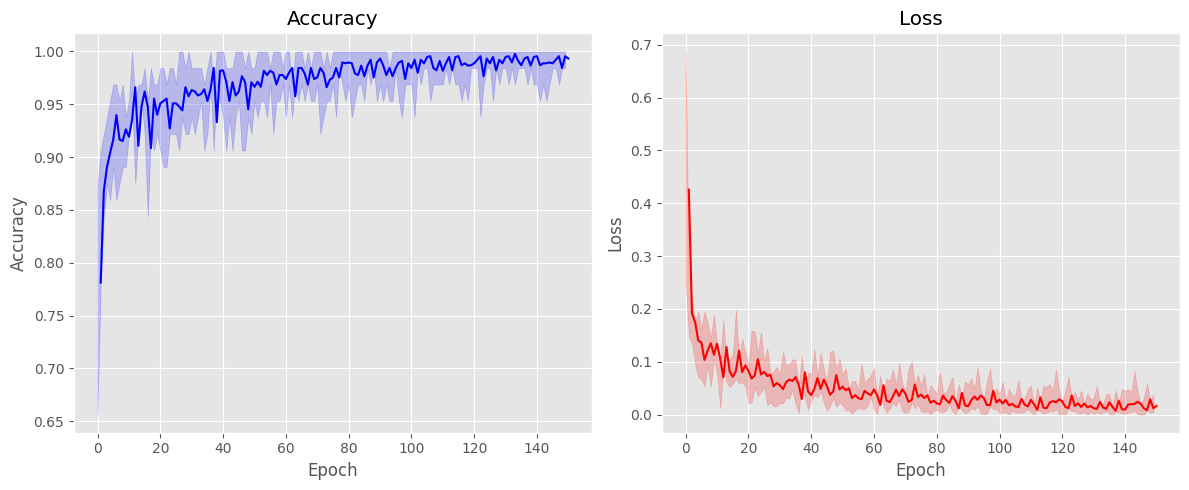

In [19]:
histories_df = pd.DataFrame(histories)
histories_df_grouped = histories_df.groupby('epoch').agg(['mean', 'min', 'max'])
accs = histories_df_grouped['accuracy']['mean']
accs_min = histories_df_grouped['accuracy']['min']
accs_max = histories_df_grouped['accuracy']['max']
losses = histories_df_grouped['loss']['mean']
losses_min = histories_df_grouped['loss']['min']
losses_max = histories_df_grouped['loss']['max']

plt.figure(figsize=(12, 5))
plt.rcParams['axes.grid'] = True

plt.subplot(1, 2, 1)
plt.plot(accs, color='b')
plt.fill_between(range(len(accs)), accs_min, accs_max, color='b', alpha=0.2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(losses, color='r')
plt.fill_between(range(len(losses)), losses_min, losses_max, color='r', alpha=0.2)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Inferencing
Making predictions with the model is as simple as running some images through the network using the `forward` function defined previously. 

In [20]:
def predict(X, W1, b1, W2, b2):
    _, _, _, a2 = forward(X, W1, b1, W2, b2)
    return a2

# Creating a Submission File

In [21]:
y_test = predict(X_test.values, W1, b1, W2, b2)
y_test = np.argmax(y_test, axis=1)

submission = pd.DataFrame({'ImageId': range(1, y_test.shape[0] + 1), 'Label': y_test})
submission.to_csv('submission.csv', index=False)

It's interesting to see how this simple neural network performs on a classification task. After making predictions with the model on the test set and submitting them to the competition, I was able to get a score of about 0.97. Given the simplicity of the model, it's surprising to see how good it performs on this task.